In [ ]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import time, datetime
import re
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error,mean_absolute_percentage_error
from IPython.display import display
pd.set_option("display.max_columns",None)
import json,pickle

# 1. Problem Statement

**Client had a problem in predicting the price of ticket for a flight**

# 2. Data Gathering and validation

**The objective of the case study is to analyse the flight booking dataset obtained from “Ease My Trip” website and to conduct various statistical hypothesis tests in order to get meaningful information from it.  'Easemytrip' is an internet platform for booking flight tickets. A thorough study of the data will aid in the discovery of valuable insights that will be of enormous value to passengers. Overall, I have to build a model that can precisely predict the ticket price.**

###### Brain Storming
*By getting problem of the client, i have some questions in my mind, which are follow*

*a) Does price vary with Airlines?*

*b) How is the price affected when tickets are bought in just 1 or 2 days before departure?*

*c) Does ticket price change based on the departure time and arrival time?*

*d) How the price changes with change in Source and Destination?*

*e) How does the ticket price vary between Economy and Business class?, etc*

###### Data is seperated in to two parts:
*one for **economy class** tickets and another for **business class** tickets.*

*A total of 300261 distinct flight booking options are available. And these are for 50 days, from February 11th to March 31st, 2022.*

### Loading the files in data frames

In [ ]:
a = pd.read_csv("business.csv")
a.head(5)

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price
0,11-02-2022,Air India,AI,868,18:00,Delhi,02h 00m,non-stop,20:00,Mumbai,"25,612"
1,11-02-2022,Air India,AI,624,19:00,Delhi,02h 15m,non-stop,21:15,Mumbai,"25,612"
2,11-02-2022,Air India,AI,531,20:00,Delhi,24h 45m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,20:45,Mumbai,"42,220"
3,11-02-2022,Air India,AI,839,21:25,Delhi,26h 30m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,23:55,Mumbai,"44,450"
4,11-02-2022,Air India,AI,544,17:15,Delhi,06h 40m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,23:55,Mumbai,"46,690"


In [ ]:
b = pd.read_csv("economy.csv")
b.head(5)

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price
0,11-02-2022,SpiceJet,SG,8709,18:55,Delhi,02h 10m,non-stop,21:05,Mumbai,"5,953"
1,11-02-2022,SpiceJet,SG,8157,06:20,Delhi,02h 20m,non-stop,08:40,Mumbai,"5,953"
2,11-02-2022,AirAsia,I5,764,04:25,Delhi,02h 10m,non-stop,06:35,Mumbai,"5,956"
3,11-02-2022,Vistara,UK,995,10:20,Delhi,02h 15m,non-stop,12:35,Mumbai,"5,955"
4,11-02-2022,Vistara,UK,963,08:50,Delhi,02h 20m,non-stop,11:10,Mumbai,"5,955"


In [ ]:
a.date.value_counts().count()

49

In [ ]:
print(a.shape)
print(b.shape)

(93487, 12)
(206774, 12)


##### Initial Preprocessing
*as we can see the there is highly noise in the data. So, we will do some cleaning and also drive some relevent featues from the given data*

*we will drive new featue named class to specify in which class the ticket is booked*

*we wil drive new featute named flight by adding ch_code and num_code of the flight*

*we will drive new feature days left by subtracting the booking date from journey date*

In [ ]:
#adding  the new feature named class
a["class"] = "business"
b["class"] = "economy"

In [ ]:
# appending two data sets and storing in the new data frame
new = b.append(a,ignore_index = True)
new.head(1)

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price,class
0,11-02-2022,SpiceJet,SG,8709,18:55,Delhi,02h 10m,non-stop,21:05,Mumbai,"5,953",economy


In [ ]:
# merging two columns (ch_code and "num_code") and making new feature flight
new.num_code = new.num_code.astype("str")
new["flight"] = new["ch_code"] +"-"+ new["num_code"]
new.drop(["ch_code","num_code"],axis = 1,inplace = True)

In [ ]:
# renaming the featuers
new.rename({"dep_time": "departure_time", "from": "source_city",
            "time_taken": "duration", "stop": "stops", "arr_time": "arrival_time",
           "to":"destination_city"}, axis = 1, inplace = True)

In [ ]:
dd = pd.DataFrame(new["date"].str.split("-",expand = True).to_numpy().astype(int),columns = ["day","month","year"])
new["days_left"] = np.where(dd["month"] > 2, dd["day"] +18, np.where(dd["month"] == 2, dd["day"] -10, dd["day"]))
new.head(1)

,date,airline,departure_time,source_city,duration,stops,arrival_time,destination_city,price,class,flight,days_left
0,11-02-2022,SpiceJet,18:55,Delhi,02h 10m,non-stop,21:05,Mumbai,"5,953",economy,SG-8709,1


In [ ]:
# as we drived one feature on the basis of date so no need for this featue so we will drop it
new.drop("date",axis = 1,inplace = True)

In [ ]:
# converting time into morning/noon/evening, etc
s = (pd.to_datetime(new["departure_time"]).dt.hour % 24 + 4) // 4 #give numbers from 1 to 6 #(return a series)
s.replace({1: 'Late Night', 2: 'Early Morning', 3: 'Morning',
                      4: 'Afternoon', 5: 'Evening', 6: 'Night'} ,inplace = True) # to replace values 1:latenight to 6: night
new["departure_time"] = s
new.head(1)

,airline,departure_time,source_city,duration,stops,arrival_time,destination_city,price,class,flight,days_left
0,SpiceJet,Evening,Delhi,02h 10m,non-stop,21:05,Mumbai,"5,953",economy,SG-8709,1


In [ ]:
# we also can get morning eveniing categories by making bins
#  our bins are (0,4,8,12,16,20,24) respected labels starts from "latenight" to "night"
temp = pd.DataFrame(new["arrival_time"].str.split(":",expand = True).to_numpy().astype(int),
                    columns = ["hour","minute"])
new["arrival_time"] = pd.cut(x = temp["hour"], bins = 6, labels =
                             ["Late Night","Early Morning","Morning", "Afternoon", "Evening", "Night"])
new.head(1)

,airline,departure_time,source_city,duration,stops,arrival_time,destination_city,price,class,flight,days_left
0,SpiceJet,Evening,Delhi,02h 10m,non-stop,Night,Mumbai,"5,953",economy,SG-8709,1


In [ ]:
# making duration in float values by calculating only hours
temp = pd.DataFrame(new["duration"].str.split(expand = True).to_numpy().astype(str),
                    columns = ["hour","minute"])
temp["hour"] = temp["hour"].apply(lambda x: re.sub("[^0-9]","",x)).astype(int)
temp["minute"] = temp["minute"].apply(lambda r: re.sub("[^0-9]","",r)) # we has no values in minute colum some where
temp["minute"] = np.where(temp["minute"] == "", 0, temp["minute"]) # replaceing "" with 0
temp["minute"] = temp["minute"].astype(int) #converting data type
new["duration"] = np.around((temp["hour"] + (temp["minute"]/60)),2) #savin the total hours in duration feature
new.head(1)

,airline,departure_time,source_city,duration,stops,arrival_time,destination_city,price,class,flight,days_left
0,SpiceJet,Evening,Delhi,2.17,non-stop,Night,Mumbai,"5,953",economy,SG-8709,1


In [ ]:
# making the stops in numeric data type by giving stops accordingly
new["stops"] = new["stops"].apply(lambda r: re.sub("[^0-9]","",r)) # taking only digits
new["stops"] = np.where(new["stops"] == "", 0, new["stops"]) # replacign "" with 0
new["stops"] = new["stops"].astype(int) # changing object to int
new.head(1)

,airline,departure_time,source_city,duration,stops,arrival_time,destination_city,price,class,flight,days_left
0,SpiceJet,Evening,Delhi,2.17,0,Night,Mumbai,"5,953",economy,SG-8709,1


In [ ]:
# removing noise from price column
new["price"] = new["price"].apply(lambda r: re.sub("[^0-9]","",r)) # taking only digits
new["price"] = new["price"].astype(int) # changing object to int
new.head(1)

,airline,departure_time,source_city,duration,stops,arrival_time,destination_city,price,class,flight,days_left
0,SpiceJet,Evening,Delhi,2.17,0,Night,Mumbai,5953,economy,SG-8709,1


In [ ]:
# arranging the features
new = new[["airline","flight","source_city","departure_time","stops",
     "arrival_time","destination_city","class","duration","days_left","price"]]

In [ ]:
# exporting the file in csv
# new.to_csv("Clean_flight_data_shaumil.csv", index = False)

**now we have clean data for our model**

The various features of the cleaned dataset are explained below:

**1) Airline:** The name of the airline company is stored in the airline column. It is a categorical feature having 6 different airlines.

**2) Flight:** Flight stores information regarding the plane's flight code. It is a categorical feature.

**3) Source City:** City from which the flight takes off. It is a categorical feature having 6 unique cities.

**4) Departure Time:** This is a derived categorical feature obtained created by grouping time periods into bins. It stores information about the departure time and have 6 unique time labels.

**5) Stops:** A categorical feature with 3 distinct values that stores the number of stops between the source and destination cities.

**6) Arrival Time:** This is a derived categorical feature created by grouping time intervals into bins. It has six distinct time labels and keeps information about the arrival time.

**7) Destination City:** City where the flight will land. It is a categorical feature having 6 unique cities.

**8) Class:** A categorical feature that contains information on seat class; it has two distinct values: Business and Economy.

**9) Duration:** A continuous feature that displays the overall amount of time it takes to travel between cities in hours.

**10)Days Left:** This is a derived characteristic that is calculated by subtracting the trip date by the booking date.

**11) Price:** Target variable stores information of the ticket price.

# EDA

In [ ]:
#making a new copy
df = new
df.sample(5)

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
29538,Air India,AI-877,Delhi,Morning,1,Afternoon,Hyderabad,economy,25.42,8,10680
132808,SpiceJet,SG-337,Kolkata,Morning,1,Night,Mumbai,economy,14.58,33,5956
152019,GO FIRST,G8-519,Kolkata,Evening,1,Early Morning,Chennai,economy,14.17,42,6985
170355,Indigo,6E-2005,Hyderabad,Afternoon,1,Evening,Bangalore,economy,4.83,46,1755
272914,Vistara,UK-774,Kolkata,Night,1,Morning,Chennai,business,12.25,7,55502


In [ ]:
# getting no null values in the data frame
df.isna().sum()

airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

In [ ]:
# getting all the details of the data frame
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300261 entries, 0 to 300260
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   airline           300261 non-null  object  
 1   flight            300261 non-null  object  
 2   source_city       300261 non-null  object  
 3   departure_time    300261 non-null  object  
 4   stops             300261 non-null  int64   
 5   arrival_time      300261 non-null  category
 6   destination_city  300261 non-null  object  
 7   class             300261 non-null  object  
 8   duration          300261 non-null  float64 
 9   days_left         300261 non-null  int64   
 10  price             300261 non-null  int64   
dtypes: category(1), float64(1), int64(3), object(6)
memory usage: 23.2+ MB
None


In [ ]:
# getting all statical insights of the numarical features
df.describe()

,stops,duration,days_left,price
count,300261.000000,300261.000000,300261.000000,300261.000000
mean,0.924213,12.219142,26.004473,20883.717666
std,0.398188,7.200348,13.560985,22695.911266
min,0.000000,0.830000,1.000000,1105.000000
25%,1.000000,6.750000,15.000000,4783.000000
50%,1.000000,11.250000,26.000000,7425.000000
75%,1.000000,16.170000,38.000000,42521.000000
max,2.000000,103.000000,49.000000,123071.000000


In [ ]:
# we has two duplicte rows
df.duplicated().sum()

2

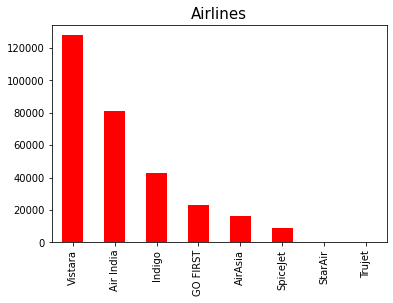

In [ ]:
# checking what are the values for each category in airline feature
df["airline"].value_counts().plot(kind = "bar",cmap='flag')
plt.title('Airlines',fontsize=15)
plt.show()

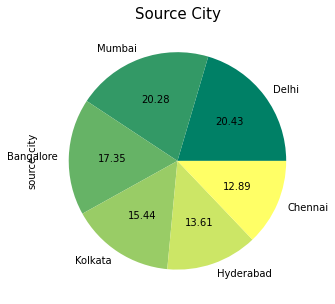

In [ ]:
# # checking what are the percentage values for each category in source_city
plt.figure(figsize = (5,5))
df['source_city'].value_counts().plot(kind = "pie", textprops={'color':'black'}, autopct = "%.2f",cmap = "summer" )
plt.title('Source City',fontsize=15)
plt.show()

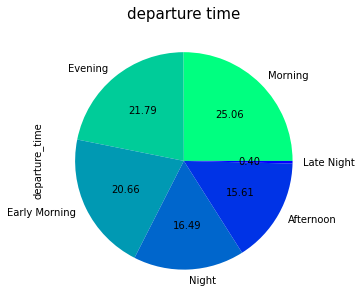

In [ ]:
# checking what are the percentage values for each category in departure time
plt.figure(figsize = (5,5))
df['departure_time'].value_counts().plot(kind = "pie",autopct = "%.2f",cmap = "winter_r" )
plt.title('departure time',fontsize=15)
plt.show()

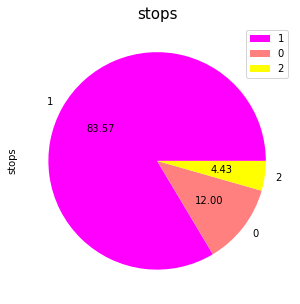

In [ ]:
# checking what are the percentage values for each category in stops feature
plt.figure(figsize = (5,5))
df['stops'].value_counts().plot(kind = "pie", textprops={'color':'black'}, autopct = "%.2f",cmap = "spring" )
plt.title('stops',fontsize=15)
plt.legend([1,0,2])
plt.show()

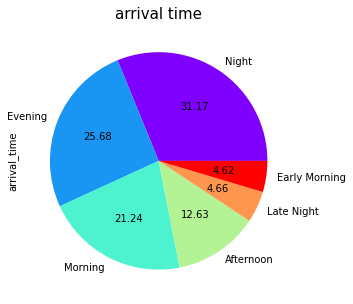

In [ ]:
# checking what are the percentage values for each category in arrival time feature
plt.figure(figsize = (5,5))
df['arrival_time'].value_counts().plot(kind = "pie",autopct = "%.2f",cmap = "rainbow" )
plt.title('arrival time',fontsize=15)
plt.show()

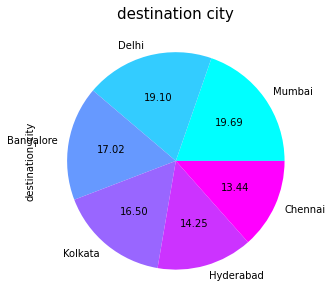

In [ ]:
# checking what are the percentage values for each category in destination city feature
plt.figure(figsize = (5,5))
df['destination_city'].value_counts().plot(kind = "pie",autopct = "%.2f",cmap = "cool" )
plt.title('destination city',fontsize=15)
plt.show()

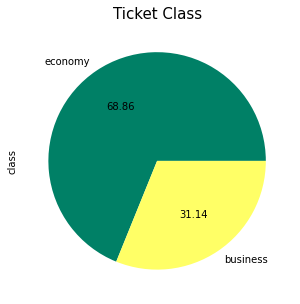

In [ ]:
# checking what are the percentage values for each category in ticket class feature
plt.figure(figsize = (5,5))
df['class'].value_counts().plot(kind = "pie",autopct = "%.2f",cmap = "summer" )
plt.title('Ticket Class',fontsize=15)
plt.show()

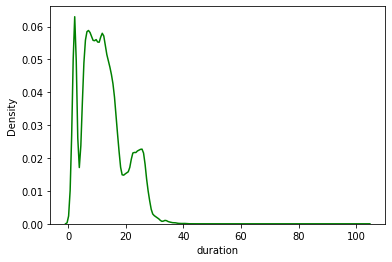

In [ ]:
# checking distribution of the duration
sns.distplot(df["duration"],hist = False,color = "green")
plt.show()

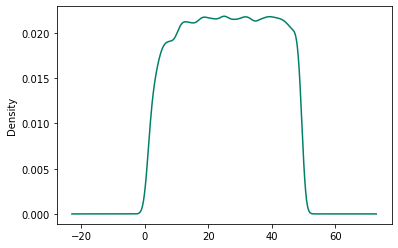

In [ ]:
# checking distribution of the days
df["days_left"].plot(kind = "kde", cmap = "summer")
plt.show()

###### Q1. Does price vary with Airlines?
**Ans:** The answer is yes Trujet is the cheapest airline and Vistara is the most expansive one.

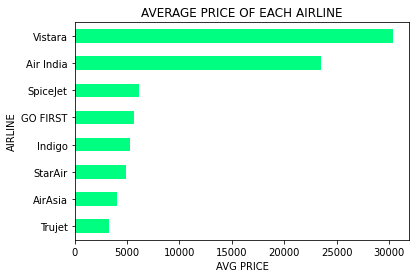

In [ ]:
s = df.groupby("airline")["price"].mean().sort_values()
s.plot(kind = "barh",cmap = "winter_r")
plt.ylabel("AIRLINE")
plt.xlabel("AVG PRICE")
plt.title("AVERAGE PRICE OF EACH AIRLINE")
plt.show()

##### Q2. How is the price affected when tickets are bought in just 1 or 2 days before departure?
**Ans:** Yes price is affected when tickets are bought in just 1 or 2 days before

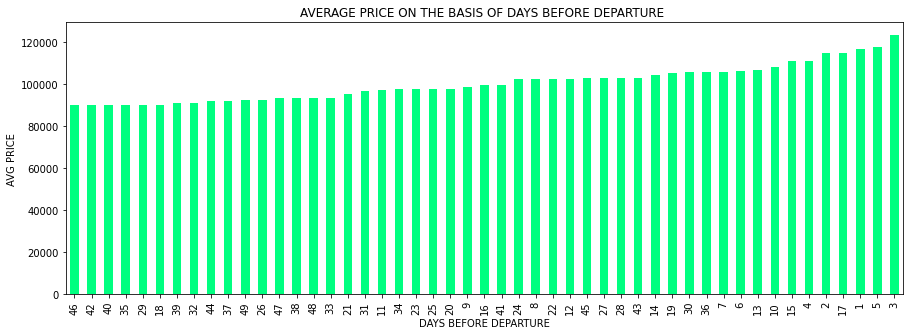

In [ ]:
plt.figure(figsize = (15,5))
s = df.groupby(["days_left"])["price"].max().sort_values()
s.plot(kind = "bar",cmap = "winter_r")
plt.ylabel("AVG PRICE")
plt.xlabel("DAYS BEFORE DEPARTURE")
plt.title("AVERAGE PRICE ON THE BASIS OF DAYS BEFORE DEPARTURE ")
plt.show()

##### Q3.  Does ticket price change based on the departure time and arrival time?
**Ans:**
**1. departure vs ticket price**

Ticket Price is More for the Flights when the Departure Time is at Night

Ticket Price is almost equal for flights Having Departure time at Early_morning , Morning and Evening

Ticket Price is Low for the Flights Having Departure Time at Late_night

**2. Arrival Time Vs Ticket Price**

Ticket Price is More for the Flights when the Arrival Time is at Evening

Ticket Price is almost equal for flights Having Arrival time is at Morning and Night

Ticket Price is Low for the Flights Having Arrival Time at Late_night as same as Departure Time

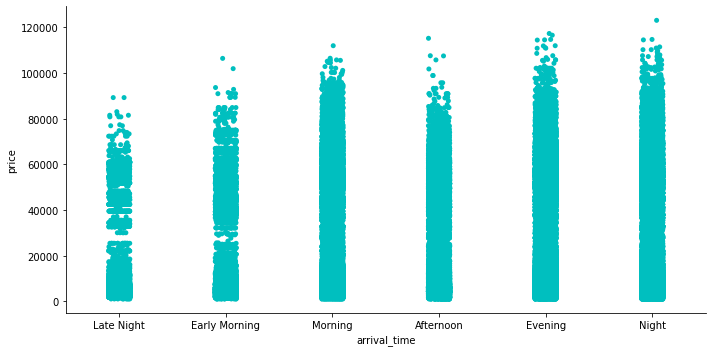

In [ ]:
sns.catplot(x='arrival_time',y='price',kind='strip',data=df,color = "c",aspect = 2)

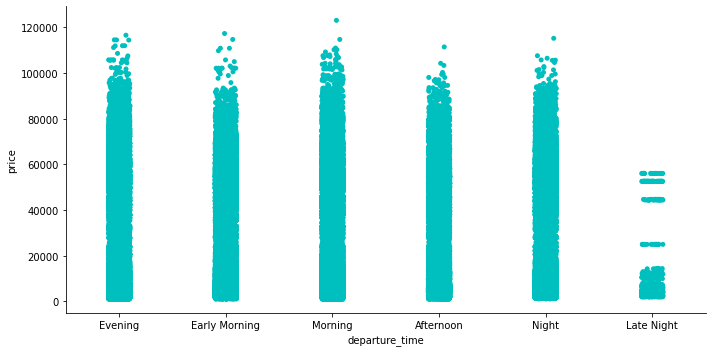

In [ ]:
sns.catplot(x='departure_time',y='price',kind='strip',data=df,color = "c",aspect = 2)

##### Q4. How the price changes with change in Source and Destination?
**Ans:** **1. Source City Vs Ticket Price**

Ticket Price is More for the Flights whose Source City is Kolkata

Ticket Price is almost equal for flights Having Source Cities as Mumbai and chennai , delhi and Bangalore

Ticket Price is Low for the Flights Having Source City as Hydrabad

**2. Destination City Vs Ticket Price**

Ticket Price is More for the Flights whose Destination City is kolkata and Delhi

Ticket Price is almost equal for flights Having Destination Cities as Mumbai and Bangalore

Ticket Price is Low for the Flights Having Destination City as Chennai

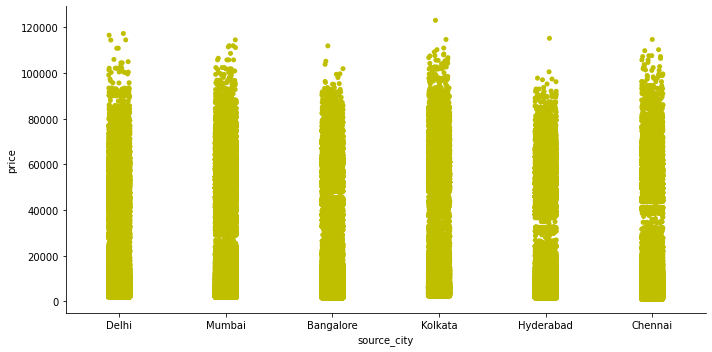

In [ ]:
sns.catplot(x='source_city',y='price',kind='strip',data=df,color = "y",aspect = 2)

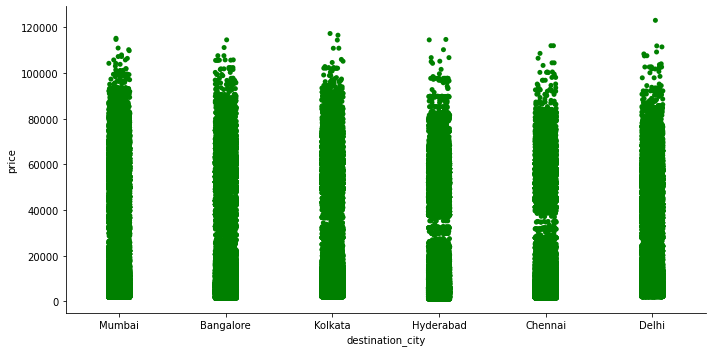

In [ ]:
sns.catplot(x='destination_city',y='price',kind='strip',data=df,color = "g",aspect = 2)

In [ ]:
# The price variation between source and destination in each airline
df.groupby(['airline','source_city','destination_city'],as_index=False)['price'].mean()

,airline,source_city,destination_city,price
0,Air India,Bangalore,Chennai,26765.567702
1,Air India,Bangalore,Delhi,20699.099886
2,Air India,Bangalore,Hyderabad,23395.956912
3,Air India,Bangalore,Kolkata,29105.826259
4,Air India,Bangalore,Mumbai,25625.530802
...,...,...,...,...
178,Vistara,Mumbai,Bangalore,35029.880315
179,Vistara,Mumbai,Chennai,32181.946251
180,Vistara,Mumbai,Delhi,26402.695114
181,Vistara,Mumbai,Hyderabad,29497.578017


In [ ]:
# here is the average price between city
pd.pivot_table(data = df,columns = "source_city",index = "destination_city", values = "price")

source_city,Bangalore,Chennai,Delhi,Hyderabad,Kolkata,Mumbai
destination_city,,,,,,
Bangalore,NaN,25081.850454,17880.216315,21245.945429,22744.808428,23147.873807
Chennai,23321.850078,NaN,19369.881354,21848.065989,23660.361040,22781.899112
Delhi,17723.313972,18981.863948,NaN,17242.639473,19422.354559,18725.320008
Hyderabad,21152.051053,21591.345404,17347.288379,NaN,21500.011397,20992.128567
Kolkata,23498.234221,22669.932407,20566.409418,20823.893201,NaN,22379.146723
Mumbai,23127.231376,22765.849647,19354.405336,20065.715179,22078.883579,NaN


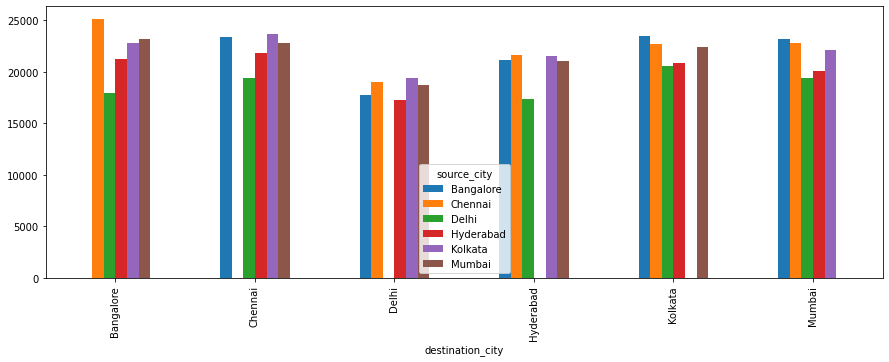

In [ ]:
# Plotting the information regarding price variance between cities
_ = pd.crosstab(columns = df["source_city"],index = df["destination_city"], values = df["price"], aggfunc="mean")
_.plot(kind = "bar",figsize = (15,5))

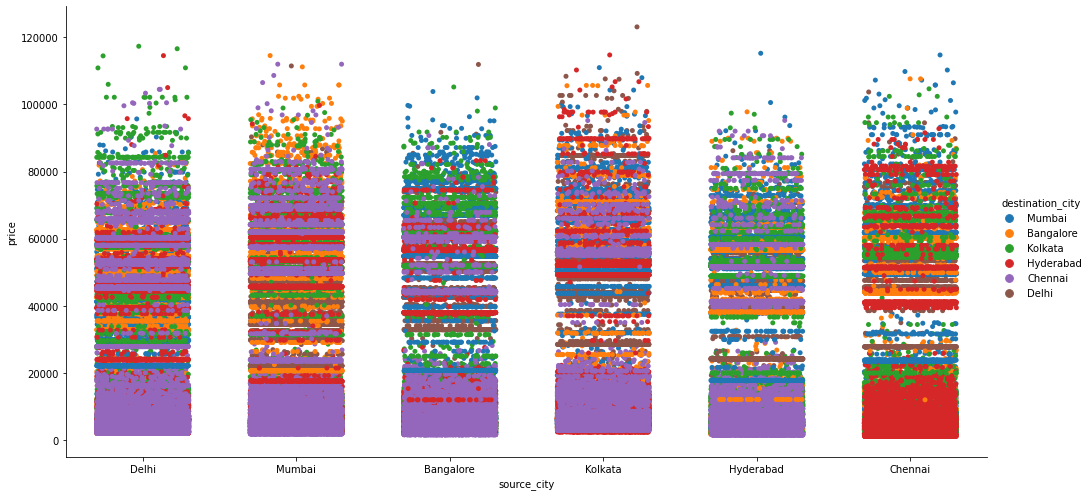

In [ ]:
# we can plot strip plot to look at the price variation in between cities
sns.catplot(data = df, x = "source_city", y = "price",
            hue = "destination_city", jitter = 0.3, aspect = 2,height = 7)

##### Q5. How does the ticket price vary between Economy and Business class?
**Ans:** The business class price is higher than economy class

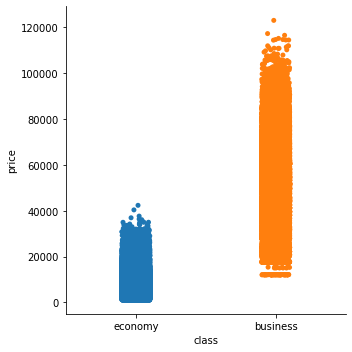

In [ ]:
sns.catplot(data = df, x = "class", y = "price", aspect = 1,height = 5)

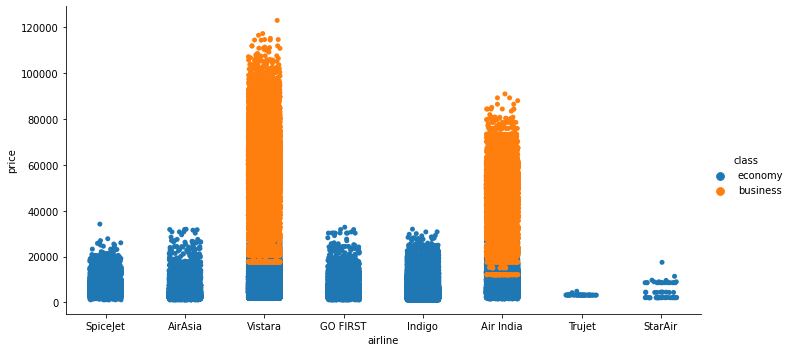

In [ ]:
sns.catplot(data = df, x = "airline", y = "price",
            hue = "class", jitter = 0.2, aspect = 2,height = 5)

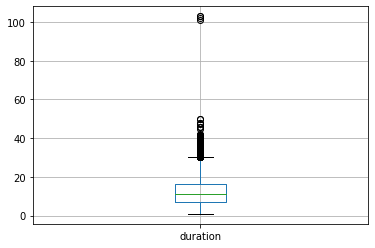

In [ ]:
#  We can see that we have outliers in duration feature but we will not replace them
#  in place of replacing them we will reduce their effect as it is
#  the real time, which is taken by flight from source and destination
df.boxplot(column ="duration")

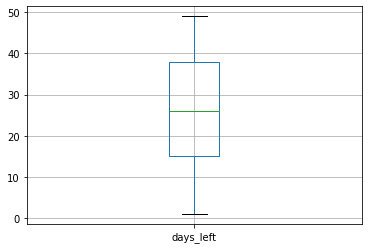

In [ ]:
df.boxplot(column ="days_left") # no outliers are found

# 4. Feature Engineering

In [ ]:
# dropping the duplicate rows
df.drop_duplicates(inplace = True)

In [ ]:
#as we have seen that we are getting information from airline so we have no need for flight feature
df1 = df.drop("flight", axis = 1)
df1.head(1)

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,Delhi,Evening,0,Night,Mumbai,economy,2.17,1,5953


In [ ]:
# as we know we have ordinal data in the following featues so we directly replace them according to order
df1["departure_time"].replace({'Late Night':0,'Early Morning':1,'Morning':2,
                               'Afternoon':3,'Evening':4,'Night':5},inplace=True)
df1["arrival_time"].replace({'Late Night':0,'Early Morning':1,'Morning':2,
                             'Afternoon':3,'Evening':4,'Night':5},inplace=True)
df1["class"].replace({"economy":0,"business":1},inplace=True)
df1.head(3)

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,Delhi,4,0,5,Mumbai,0,2.17,1,5953
1,SpiceJet,Delhi,1,0,2,Mumbai,0,2.33,1,5953
2,AirAsia,Delhi,1,0,1,Mumbai,0,2.17,1,5956


In [ ]:
# encoding for nominal data (we will use onehot encoder)

ohe = OneHotEncoder()
df1[list(df1["airline"].unique())] = ohe.fit_transform(df1[["airline"]]).A # making sparse metrics to metrics
df1 = pd.concat([df1,pd.get_dummies(df1["destination_city"],prefix = "destination_city")], axis = 1)
df1 = pd.concat([df1,pd.get_dummies(df1["source_city"],prefix = "source_city")], axis = 1)
df1.drop(["airline","source_city","destination_city"],axis = 1,inplace=True)
df1.head(1)

,departure_time,stops,arrival_time,class,duration,days_left,price,SpiceJet,AirAsia,Vistara,GO FIRST,Indigo,Air India,Trujet,StarAir,destination_city_Bangalore,destination_city_Chennai,destination_city_Delhi,destination_city_Hyderabad,destination_city_Kolkata,destination_city_Mumbai,source_city_Bangalore,source_city_Chennai,source_city_Delhi,source_city_Hyderabad,source_city_Kolkata,source_city_Mumbai
0,4,0,5,0,2.17,1,5953,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,1,0,0,0


# 5. Feature Selection

In [ ]:
# As we can see there is low dimentionality of the data no need for high feature selections
# if we will drop some featuers so there is high chances that our model will be undercutted.
# That's why we will see the model perfomance without feature selection first.

# 6. Model Selection and Training

In [ ]:
# seperating the dependent and independent variables
x = df1.drop("price", axis = 1)
y = df1["price"]

In [ ]:
# splitting the data for training as well as testing purpose
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.33,random_state=42)

### A. Model selection

In [ ]:
def get_prediction(model):
    model.fit(x_train,y_train)
    y_pred = model.predict(x_train)
    maep_tr = mean_absolute_percentage_error(y_train,y_pred)
    r2_tr  = r2_score(y_train,y_pred)
    y_pred1 = model.predict(x_test)
    maep_te = mean_absolute_percentage_error(y_test,y_pred1)
    r2_te  = r2_score(y_test,y_pred1)
    return print(f"""At Training: \n%MAE: {maep_tr}\nR2_Score: {r2_tr}
    \nAt Testing: \n%MAE: {maep_te}\nR2_Score: {r2_te}""")

In [ ]:
#  without scalling model performances
lst = [("Linear Regression",LinearRegression()),("Decision Tree",DecisionTreeRegressor()),
      ("Random Forest",RandomForestRegressor()),("AdaBoost",AdaBoostRegressor()),
      ("XG Boost",XGBRegressor())]
for name,model in lst:
    print(f"The Performance of {name} without Scaling::")
    get_prediction(model)
    print("*"*50)

The Performance of Linear Regression without Scaling::
At Training: 
%MAE: 0.4291582774155693
R2_Score: 0.9093493429288637
    
At Testing: 
%MAE: 0.4309474258455599
R2_Score: 0.9101065276667424
**************************************************
The Performance of Decision Tree without Scaling::
At Training: 
%MAE: 0.0022414509454554417
R2_Score: 0.999382532773985
    
At Testing: 
%MAE: 0.07685841801953003
R2_Score: 0.9763329725058691
**************************************************
The Performance of Random Forest without Scaling::
At Training: 
%MAE: 0.028204429427322146
R2_Score: 0.9974931294763486
    
At Testing: 
%MAE: 0.07326628062208349
R2_Score: 0.9851653853356991
**************************************************
The Performance of AdaBoost without Scaling::
At Training: 
%MAE: 0.28452131705836986
R2_Score: 0.9369122386590789
    
At Testing: 
%MAE: 0.2864859992983584
R2_Score: 0.9367993958556207
**************************************************
The Performance of XG Boos

In [ ]:
# scalling the data
# to skip data leackage we will fit only on training data
std = StandardScaler()
x_train = pd.DataFrame(std.fit_transform(x_train), columns = x_train.columns)
x_test = pd.DataFrame(std.transform(x_test),columns = x_test.columns)

In [ ]:
#  with scalling model performances
lst = [("Linear Regression",LinearRegression()),("Decision Tree",DecisionTreeRegressor()),
      ("Random Forest",RandomForestRegressor()),("AdaBoost",AdaBoostRegressor()),
      ("XG Boost",XGBRegressor())]
for name,model in lst:
    print(f"The Performance of {name} with Scaling::")
    get_prediction(model)
    print("*"*50)

The Performance of Linear Regression with Scaling::
At Training: 
%MAE: 0.4267517085869763
R2_Score: 0.909336212012579
    
At Testing: 
%MAE: 0.42847985718506326
R2_Score: 0.9100919836061571
**************************************************
The Performance of Decision Tree with Scaling::
At Training: 
%MAE: 0.0022414509454554417
R2_Score: 0.999382532773985
    
At Testing: 
%MAE: 0.07660822376580077
R2_Score: 0.9765361506764836
**************************************************
The Performance of Random Forest with Scaling::
At Training: 
%MAE: 0.028068294195706816
R2_Score: 0.9974935958624424
    
At Testing: 
%MAE: 0.07288289298389054
R2_Score: 0.9852154043125813
**************************************************
The Performance of AdaBoost with Scaling::
At Training: 
%MAE: 0.3800931586929806
R2_Score: 0.9295185079484729
    
At Testing: 
%MAE: 0.3835822262232064
R2_Score: 0.9290692374592956
**************************************************
The Performance of XG Boost with Scalin

**as we can see the random forest has good r2 values at the time of training as well as testing also has lowest %mae. so we will go with the random forest model. NO need to optimise model**

### B. Model Training

In [ ]:
# Training the model
rf = RandomForestRegressor()
rf.fit(x_train,y_train)

RandomForestRegressor()

# 7. Evaluation

In [ ]:
# predicting the values
y_pred = rf.predict(x_test)
y_pred

array([35732.32, 38099.  , 10659.9 , ...,  1604.  , 10806.11, 64140.52])

In [ ]:
r2     = r2_score(y_test,y_pred)
mape    = mean_absolute_percentage_error(y_test,y_pred)
print(f"The Performace of the model::\nR2_score: {r2}\n%MAE: {mape}")

The Performace of the model::
R2_score: 0.9852343636188092
%MAE: 0.07310028114646965


**We can see the goodness of best fit line is 98%, which is quite acceptable. Now we will export files for production**